## **PROJET INFO-F422**

L'objectif principal est de développer des modèles de régression capables de prédire les angles continus d'articulation de la main (51 valeurs) à partir de signaux d'électromyographie de surface (SEMG) enregistrés sur l'avant-bras d'un participant. Le projet utilise deux ensembles de données : un pour des gestes guidés prédéfinis et un autre pour des gestes libres et naturels.

**PLAN:**


1.   Explorer les données
2.   Faire du data processing



Types de données:


*   Signaux SEMG (Surface Electromyography) bruts : Ce sont les données
d'entrée principales. Elles proviennent de **8 capteurs** sans fil placés sur l'avant-bras du participant et mesurent l'activité électrique des muscles. Les signaux SEMG, qui constituent vos données d'entrée (souvent notées X ou x_t), représentent les potentiels électriques, c'est-à-dire le voltage, généré par l'activité musculaire de l'avant-bras, mesuré par 8 électrodes. Ces mesures de voltage sont prises à une fréquence élevée de 1024 Hz, fournissant ainsi 1024 échantillons par seconde pour chaque électrode.

* Angles d'Articulation de la Main (Hand Pose) : Ce sont les données cibles (à prédire). Elles consistent en **51 valeurs continues** représentant les angles de 17 articulations de la main, capturées par un casque VR (Oculus Quest).

## Shapes des Données (Format Fichiers .npy)

Basé sur le document du projet:

### 1. Données "Guided Gestures"

* **`guided_dataset_X.npy`** (Entrée Entraînement/Validation - SEMG):
    * **Shape**: `(5, 8, 230000)`
    * *Dimensions*: (session, électrode, temps)
* **`guided_dataset_y.npy`** (Cible Entraînement/Validation - Pose):
    * **Shape**: `(5, 51, 230000)`
    * *Dimensions*: (session, angle articulaire, temps)
* **`guided_testset_X.npy`** (Entrée Test - SEMG):
    * **Shape**: `(5, 332, 8, 500)`
    * *Dimensions*: (session, fenêtre, électrode, temps dans la fenêtre)

### 2. Données "Free Gestures"

* **`freemoves_dataset_X.npy`** (Entrée Entraînement/Validation - SEMG):
    * **Shape**: `(5, 8, 270000)`
    * *Dimensions*: (session, électrode, temps)
* **`freemoves_dataset_y.npy`** (Cible Entraînement/Validation - Pose):
    * **Shape**: `(5, 51, 270000)`
    * *Dimensions*: (session, angle articulaire, temps)
* **`freemoves_testset_X.npy`** (Entrée Test - SEMG):
    * **Shape**: `(5, 308, 8, 500)`
    * *Dimensions*: (session, fenêtre, électrode, temps dans la fenêtre)

### 3. Shapes Attendues pour la Soumission

* Prédictions pour `guided_testset_X.npy`: **`(1660, 51)`**
* Prédictions pour `freemoves_testset_X.npy`: **`(1540, 51)`**
* Fichier `.csv` final (concaténé): **`(3200, 51)`**

In [32]:
# PATH TO DATA
import numpy as np
user_path = {}
user_path['N'] = ['/content/gdrive/My Drive/B. Statistical/Projet/F422 EMG project data/guided/guided_dataset_X.npy',
               '/content/gdrive/My Drive/B. Statistical/Projet/F422 EMG project data/guided/guided_dataset_y.npy']
user_path['B'] = ['guided/guided_dataset_X.npy',
'guided/guided_dataset_y.npy']

file_pathX = user_path["B"][0]
file_pathY = user_path["B"][1]

# Verification of the files

try:
    dataX = np.load(file_pathX)
    print("DataX loaded successfully.")
    print("Shape of dataX:", dataX.shape)
    print("DataX type:", dataX.dtype)
    print("First dataX point:\n", dataX[0])
except FileNotFoundError:
    print(f"Error: File not found at {file_pathX}. Please check the path.")
except Exception as e:
    print(f"An error occurred while loading dataX: {e}")

# Chargement de y
try:
    dataY = np.load(file_pathY)
    print("\nDataY loaded successfully.")
    print("Shape of dataY:", dataY.shape)
    print("DataY type:", dataY.dtype)
    print("First dataY point:\n", dataY[0])
except FileNotFoundError:
    print(f"Error: File not found at {file_pathY}. Please check the path.")
except Exception as e:
    print(f"An error occurred while loading dataY: {e}")



DataX loaded successfully.
Shape of dataX: (5, 8, 230000)
DataX type: float64
First dataX point:
 [[   1.44750255   11.44884926   10.96660197 ...  -22.93242336
   -21.72570544   -7.65323851]
 [  -2.51984184  -27.13716915  -25.66957507 ...  -63.51726696
   -90.84048287 -130.08522851]
 [  -3.43154776   13.04230939   30.18778912 ...  -66.2548037
   -25.41721285   14.15463125]
 ...
 [  -6.1280614    -8.28674783   -0.59649155 ...   26.49171167
     6.79468467   -4.41795844]
 [   6.58512385   -6.81869229    8.88339399 ...   28.15838739
    -3.93034395    1.29360119]
 [   8.03271333   14.30733642    8.02125107 ...  -24.54067981
   -17.17460447  -24.10335111]]

DataY loaded successfully.
Shape of dataY: (5, 51, 230000)
DataY type: float64
First dataY point:
 [[ 42.55583091  42.55387979  42.55209465 ...  41.44924719  41.44708451
   41.44482898]
 [-65.65864111 -65.65654444 -65.65458765 ... -64.62804464 -64.62657029
  -64.62503839]
 [-36.76667437 -36.758701   -36.75135135 ... -32.52761358 -32.520

In [33]:
# LOAD INPUT DATA

import numpy as np
import pandas as pd

# Store the data in a dictionary for easy access
data = {
    'X': {},  # EMG data
    'y': {}   # Labels
}
# Explore the different sessions in the dataset
for session in range(dataX.shape[0]):
    # Store the session data 
    session_data = dataX[session] # Shape will be (8, 230000) for this session

    # Transpose the data: time points become rows, electrodes become columns
    session_input = session_data.T # Shape becomes (230000, 8)

    # Define column names for the EMG electrodes (should be 8 columns)
    electrode_columns = [f'EMG_{i+1}' for i in range(session_data.shape[0])] # Use session_data shape for columns

    # Create a pandas DataFrame for the *first 10 time points* of the transposed data
    # This is just for display purposes to avoid printing huge tables.
    data['X'][session] = pd.DataFrame(session_input, columns=electrode_columns)

    # Add a 'Time_Sample' index name for clarity
    data['X'][session].index.name = 'Time_Sample'

    # Retake the right format for the data
    data['X'][session] = data['X'][session].T

    data['X'][session] = data['X'][session] # Store the DataFrame back in the dictionary
    
# Display the first 10 time points for the selected session
#print(f"\nFirst 10 time points for Session {session_index + 1}:")
print(data['X'][0])    
#print("-" * 30)


Time_Sample     0          1          2          3          4          5       \
EMG_1         1.447503  11.448849  10.966602  -0.372605  -1.220629  -1.395730   
EMG_2        -2.519842 -27.137169 -25.669575  -9.807298   7.147789  10.744989   
EMG_3        -3.431548  13.042309  30.187789   8.831421  -7.101316   3.253534   
EMG_4       -14.551101  12.344713  17.807764  19.798811   1.545637   1.535868   
EMG_5         9.008999  -5.894418  -1.391771 -11.487393   3.036702  -6.069433   
EMG_6        -6.128061  -8.286748  -0.596492  -2.230163 -13.426975 -12.943470   
EMG_7         6.585124  -6.818692   8.883394  -1.178838  -3.173392   4.974815   
EMG_8         8.032713  14.307336   8.021251   3.123762   6.136862   7.669919   

Time_Sample    6          7          8         9       ...     229990  \
EMG_1       -2.202977  -2.100518  -2.192419 -5.772013  ... -26.529012   
EMG_2        6.184262  11.659288   3.068883  4.933054  ...  26.643876   
EMG_3        8.019242  15.551035   5.323104 -9.3230

In [34]:
# LOAD OUTPUT DATA

for session in range(dataX.shape[0]):

    # Store the session data
    session_data = dataY[session]  

    # Transpose the data: time points become rows, electrodes become columns
    session_output = session_data.T 

    # Define column names for the different positions 
    position_columns = [f'Position_{i+1}' for i in range(session_output.shape[1])]

    print (f"Session {session} shape: {session_output.shape}")
    # Transform the session data into a pandas DataFrame
    df_output = pd.DataFrame(session_output, columns=position_columns)

    # Add a 'Time_Sample' index name for clarity
    df_output.index.name = 'Time_Sample'

    # Retake the right format for the data
    df_output = df_output.T

    # Store the DataFrame back in the dictionary
    data['y'][session] = df_output

# Display the first 10 time points for the selected session
#print(f"\nFirst 10 time points for Session {session_index + 1}:")
print(data['y'][0])
#print("-" * 30)



Session 0 shape: (230000, 51)
Session 1 shape: (230000, 51)
Session 2 shape: (230000, 51)
Session 3 shape: (230000, 51)
Session 4 shape: (230000, 51)
Time_Sample     0          1          2          3          4          5       \
Position_1   42.555831  42.553880  42.552095  42.550542  42.549171  42.547960   
Position_2  -65.658641 -65.656544 -65.654588 -65.652847 -65.651273 -65.649848   
Position_3  -36.766674 -36.758701 -36.751351 -36.744879 -36.739104 -36.733935   
Position_4   29.562305  29.558308  29.554308  29.550309  29.546320  29.542347   
Position_5   -6.883659  -6.906019  -6.928427  -6.950878  -6.973312  -6.995679   
Position_6  -16.659136 -16.670179 -16.681247 -16.692339 -16.703424 -16.714478   
Position_7   -7.239894  -7.240577  -7.241262  -7.241950  -7.242642  -7.243337   
Position_8    7.365142   7.365649   7.366157   7.366667   7.367180   7.367695   
Position_9  -36.340163 -36.327813 -36.315418 -36.302963 -36.290441 -36.277853   
Position_10   8.975887   8.976946   8.97

In [35]:

# https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
def calculate_zc_row(row):
  """Calculates the number of zero crossings in a pandas Series (representing a row)."""
  return len(np.where(np.diff(np.signbit(row)))[0])

In [36]:
# CREATE THE X VECTOR FOR EACH SESSION

OVERLAPPING = 0.5  # 50% overlap

N_of_iter = (data['X'][session].shape[1]//500)

X = {}

for session in range(dataX.shape[0]):
    # Create a new DataFrame to store the final features
    for i in np.arange(0, N_of_iter - OVERLAPPING, OVERLAPPING):
        start_wnd = int(i * 500)
        end_wnd = start_wnd + 500
        window_data = data['X'][session].iloc[:, start_wnd:end_wnd]
        # Add the window data to the final features DataFrame
        window_features = pd.DataFrame()
        window_features['MAV'] = window_data.abs().mean(axis=1)
        # Add RMS to the input DataFrame
        window_features['RMS'] = np.sqrt((window_data**2).mean(axis=1))
        # Add Variance to the input DataFrame
        window_features['Variance'] = window_data.var(axis=1)
        # Add Standard Deviation to the input DataFrame
        window_features['Standard_Deviation'] = window_data.std(axis=1)
        # Add Myopulse percentage rate to the input DataFrame
        window_features['Myopulse_Percentage'] = (window_data > 0).mean(axis=1) * 100
        # Zero Crossing Rate
        window_features['Zero_Crossing_Rate'] = window_data.apply(calculate_zc_row, axis=1)
        # Add Mean Frequency to the input DataFrame
        window_features['Mean_Frequency'] = window_data.apply(lambda x: np.sum(x * np.arange(1, len(x) + 1)) / np.sum(x), axis=1)
        # Add Median Frequency to the input DataFrame
        window_features['Median_Frequency'] = window_data.apply(lambda x: np.median(x), axis=1)

        #print(f"Window {int(i*2)+1} features:")
        #print(window_features)  # Display the first 10 rows of the features for this window


        X[f'Feature_Vector_{int(i*2)+1}_session_{session}'] = window_features.values.flatten()


In [37]:
# CREATE A DATAFRAME FOR THE X VECTOR

# Create a DataFrame from the dictionary
X_df = pd.DataFrame.from_dict(X, orient='index')

# Set the column names for the features MAV, RMS, Variance, Standard Deviation, Myopulse Percentage, Zero Crossing Rate, Mean Frequency, Median Frequency per emg electrode
X_df.columns = [f'{feature}_EMG_{i+1}' for i in range(8) for feature in ['MAV', 'RMS', 'Variance', 'Standard_Deviation', 'Myopulse_Percentage', 'Zero_Crossing_Rate', 'Mean_Frequency', 'Median_Frequency']]

In [38]:
print(X_df.head())  # Display the first 5 rows of the DataFrame

                            MAV_EMG_1  RMS_EMG_1  Variance_EMG_1  \
Feature_Vector_1_session_0   6.701652   8.662048       75.033941   
Feature_Vector_2_session_0   7.178799   9.199120       84.785960   
Feature_Vector_3_session_0   9.718116  14.565290      212.466192   
Feature_Vector_4_session_0  32.977899  52.550206     2767.058016   
Feature_Vector_5_session_0  44.143445  59.523193     3549.881294   

                            Standard_Deviation_EMG_1  \
Feature_Vector_1_session_0                  8.662213   
Feature_Vector_2_session_0                  9.207929   
Feature_Vector_3_session_0                 14.576220   
Feature_Vector_4_session_0                 52.602833   
Feature_Vector_5_session_0                 59.580880   

                            Myopulse_Percentage_EMG_1  \
Feature_Vector_1_session_0                       47.0   
Feature_Vector_2_session_0                       46.2   
Feature_Vector_3_session_0                       45.2   
Feature_Vector_4_session_0

In [39]:
print(df_output)

Time_Sample      0           1           2           3           4       \
Position_1    42.290463   42.292368   42.293908   42.295165   42.296189   
Position_2   -65.392441  -65.394528  -65.396297  -65.397822  -65.399145   
Position_3   -35.716676  -35.724505  -35.730961  -35.736367  -35.740888   
Position_4    30.216898   30.218049   30.219342   30.220721   30.222153   
Position_5    -2.926586   -2.914814   -2.901579   -2.887445   -2.872765   
Position_6   -14.687717  -14.681667  -14.674861  -14.667593  -14.660043   
Position_7    -7.169655   -7.170388   -7.171225   -7.172124   -7.173062   
Position_8     7.312839    7.313251    7.313721    7.314226    7.314752   
Position_9   -37.612358  -37.600093  -37.586100  -37.571046  -37.555361   
Position_10    6.359725    6.360863    6.362156    6.363543    6.364982   
Position_11   -5.837174   -5.837819   -5.838551   -5.839336   -5.840149   
Position_12  -40.271729  -40.256163  -40.238495  -40.219536  -40.199879   
Position_13    4.690525  

In [40]:
# CREATE THE Y VECTOR FOR EACH SESSION

Y = {}
for session in range(dataX.shape[0]):
    for i in np.arange(0, N_of_iter - OVERLAPPING, OVERLAPPING):
        start_wnd = int(i * 500)
        end_wnd = start_wnd + 500
        Y[f'Feature_Vector_{int(i*2)+1}_session_{session}'] = df_output[end_wnd-1].values.flatten()  # Use the last column of the window


In [41]:
# CREATE A DATAFRAME FOR THE Y VECTOR

# Create a DataFrame from the dictionary
Y_df = pd.DataFrame.from_dict(Y, orient='index')
print(Y_df.head(10))  # Display the first 10 rows of the DataFrame
#Set the column names for the 51 positions
Y_df.columns = [f'Position_{i+1}' for i in range(51)]

                                    0          1          2          3   \
Feature_Vector_1_session_0   42.086326 -65.199592 -34.929309  30.022924   
Feature_Vector_2_session_0   40.854087 -64.152110 -30.382526  29.989464   
Feature_Vector_3_session_0   34.971024 -61.266388 -11.893879  30.226913   
Feature_Vector_4_session_0   26.672331 -61.133342  10.241771  30.191758   
Feature_Vector_5_session_0   30.546592 -60.725305   0.155662  31.229629   
Feature_Vector_6_session_0   31.633812 -60.752808  -2.726731  31.032291   
Feature_Vector_7_session_0   31.221229 -60.734317  -1.628149  31.125219   
Feature_Vector_8_session_0   30.698690 -60.724659  -0.245108  30.995176   
Feature_Vector_9_session_0   30.772386 -60.725045  -0.439560  30.946713   
Feature_Vector_10_session_0  31.395754 -60.740970  -2.092103  30.825258   

                                   4          5         6         7   \
Feature_Vector_1_session_0  -4.166967 -15.309286 -7.169404  7.311525   
Feature_Vector_2_session_0  -4

In [42]:
print(len(X))
print(len(Y))

4595
4595


In [43]:
X_df.describe()  # Display the first 10 rows of the DataFrame

,MAV_EMG_1,RMS_EMG_1,Variance_EMG_1,Standard_Deviation_EMG_1,Myopulse_Percentage_EMG_1,Zero_Crossing_Rate_EMG_1,Mean_Frequency_EMG_1,Median_Frequency_EMG_1,MAV_EMG_2,RMS_EMG_2,...,Mean_Frequency_EMG_7,Median_Frequency_EMG_7,MAV_EMG_8,RMS_EMG_8,Variance_EMG_8,Standard_Deviation_EMG_8,Myopulse_Percentage_EMG_8,Zero_Crossing_Rate_EMG_8,Mean_Frequency_EMG_8,Median_Frequency_EMG_8
count,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4.595000e+03,4595.000000,4595.000000,4595.000000,...,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000
mean,24.322097,33.453146,1907.664027,33.477431,48.979804,119.458977,5.493655e+02,-0.502150,82.386295,111.502775,...,236.938404,-0.662422,39.264017,60.805872,5301.512299,60.755338,55.109728,113.660065,264.995780,2.260433
std,15.897562,28.033440,5610.364819,28.055248,2.078748,11.176845,3.231668e+04,1.588777,37.919955,62.155159,...,2972.604643,0.797206,25.697068,40.024845,6008.303299,40.132926,4.146440,23.867592,928.985175,1.892678
min,3.938931,5.028034,25.170259,5.016997,42.400000,78.000000,-6.706668e+05,-11.611451,4.735261,6.014758,...,-92004.359248,-6.033499,4.709952,6.098553,32.560692,5.706198,44.200000,55.000000,-20860.346163,-8.969277
25%,16.177022,20.713930,429.574352,20.726175,47.600000,112.000000,8.316713e+01,-1.358387,63.295453,82.741988,...,150.932585,-1.078718,15.764015,22.905305,519.672333,22.796320,52.200000,97.000000,220.592230,1.417284
50%,19.109275,24.396675,596.274038,24.418723,49.000000,120.000000,2.528660e+02,-0.609705,74.359966,96.802805,...,249.256828,-0.640571,36.057057,55.434270,3073.023233,55.434856,54.600000,107.000000,253.538081,2.174665
75%,25.495276,33.043491,1093.885910,33.073946,50.400000,127.000000,4.223238e+02,0.184072,88.805191,117.014583,...,346.289178,-0.204584,59.434464,92.617304,8585.654984,92.658809,57.600000,126.000000,289.269640,2.979902
max,179.632667,306.285841,93846.098442,306.343106,58.200000,199.000000,2.064580e+06,14.058542,341.016922,529.002661,...,73845.728361,5.954107,180.092613,279.746443,78399.283402,279.998720,69.000000,208.000000,39089.181230,19.635145


In [44]:
Y_df.describe()  # Display the first 10 rows of the DataFrame

,Position_1,Position_2,Position_3,Position_4,Position_5,Position_6,Position_7,Position_8,Position_9,Position_10,...,Position_42,Position_43,Position_44,Position_45,Position_46,Position_47,Position_48,Position_49,Position_50,Position_51
count,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,...,4595.0000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000
mean,34.056098,-61.498245,-9.835739,30.854435,2.922714,-11.692690,-8.494104,7.876489,-16.412158,9.757605,...,-5.8475,10.024845,9.048219,-12.742775,-5.306220,5.526163,-28.427289,-0.535638,-5.412842,-15.074803
std,3.472835,1.427203,10.574451,0.476530,4.766314,2.448998,0.825032,0.357342,13.270371,1.770916,...,0.0000,0.957025,4.222721,26.375010,0.833793,1.217082,36.466896,0.739948,0.437315,19.414356
min,26.672331,-68.618897,-47.245063,28.608071,-11.653887,-18.978748,-10.024081,6.746179,-49.499482,5.495360,...,-5.8475,7.863220,-1.764066,-84.011450,-7.010780,4.873608,-106.711995,-2.378817,-5.636456,-69.965073
25%,32.017029,-61.045274,-9.124768,30.622460,0.074241,-13.167342,-9.001094,7.922975,-18.899826,10.032351,...,-5.8475,10.177767,6.957332,-6.682005,-5.242275,4.902549,-18.262505,-0.456348,-5.630406,-11.880811
50%,32.761662,-60.852066,-5.762407,30.939540,2.874452,-11.734089,-8.624310,8.020630,-13.907600,10.504829,...,-5.8475,10.428215,10.419859,-1.361179,-4.932495,4.922804,-11.148066,-0.203203,-5.620625,-6.275799
75%,33.986009,-60.779932,-3.744259,31.202689,5.777066,-10.235839,-8.296223,8.095454,-8.298116,10.791919,...,-5.8475,10.553413,11.710761,1.538570,-4.816231,5.004415,-8.525209,-0.094067,-5.580274,-3.881858
max,44.928242,-60.723897,10.241771,31.603551,20.304752,-2.644538,-6.579150,8.137032,6.714728,11.182037,...,-5.8475,11.608331,20.814592,24.681866,-4.372977,8.208076,1.332681,0.120605,-3.913330,0.811386


In [45]:
# Get rid of the columns with zero variance
X_df = X_df.loc[:, (X_df != X_df.iloc[0]).any()]
Y_df = Y_df.loc[:, (Y_df != Y_df.iloc[0]).any()]
# Display the new shape of the DataFrame
print("New shape of X_df:", X_df.shape)
print("New shape of Y_df:", Y_df.shape)

New shape of X_df: (4595, 64)
New shape of Y_df: (4595, 48)


In [46]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.25, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3446, 64)
X_test shape: (1149, 64)
y_train shape: (3446, 48)
y_test shape: (1149, 48)


In [47]:
# Split the data into training and testing sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print("X_train shape:", X_train_final.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train_final.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2584, 64)
X_val shape: (862, 64)
y_train shape: (2584, 48)
y_val shape: (862, 48)


In [48]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

def nmse(y, y_hat):
    return np.mean((y-y_hat)**2)/np.std(y)**2

In [49]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
Y_hat = model.predict(X_test)

empirical_mse = nmse(y_test, Y_hat)
print("Empirical NMSE:", empirical_mse)


Empirical NMSE: Position_1         14.467486
Position_2         87.831664
Position_3          1.567173
Position_4        760.837920
Position_5          7.629677
Position_6         28.905379
Position_7        253.267984
Position_8       1302.412025
Position_9          0.973328
Position_10        52.904604
Position_11       561.393375
Position_12         0.310474
Position_13       732.720847
Position_14        42.337567
Position_15         0.548603
Position_16    147946.908565
Position_17     53048.132730
Position_18         0.126725
Position_19      1002.988755
Position_20      2123.725016
Position_21         0.273555
Position_22     11020.967708
Position_23        78.480031
Position_24         0.454835
Position_25    108425.106629
Position_26     49886.599451
Position_27         0.115276
Position_28        58.688055
Position_29       149.567924
Position_30         0.366244
Position_31      8810.732722
Position_32        77.145069
Position_33         0.324341
Position_34       813.20728

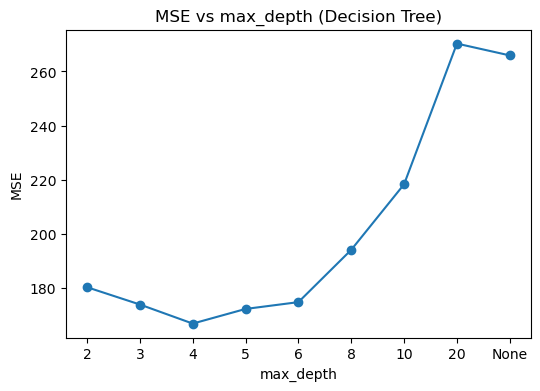

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

depths = [2, 3, 4, 5, 6, 8, 10, 20, None]
mse_values_tree = []

for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train_final, y_train_final)
    y_pred_dt = dt.predict(X_val)
    mse_values_tree.append(mse(y_val, y_pred_dt))

plt.figure(figsize=(6,4))
plt.plot([str(d) for d in depths], mse_values_tree, marker='o')
plt.title("MSE vs max_depth (Decision Tree)")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()

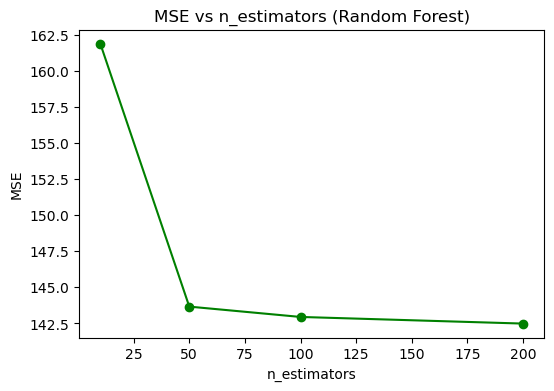

In [51]:
estimators_range = [10, 50, 100, 200]
mse_values_rf = []

for n in estimators_range:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train_final, y_train_final)
    y_pred_rf = rf.predict(X_val)
    mse_values_rf.append(mse(y_val, y_pred_rf))

plt.figure(figsize=(6,4))
plt.plot(estimators_range, mse_values_rf, marker='o', color='green')
plt.title("MSE vs n_estimators (Random Forest)")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.show()

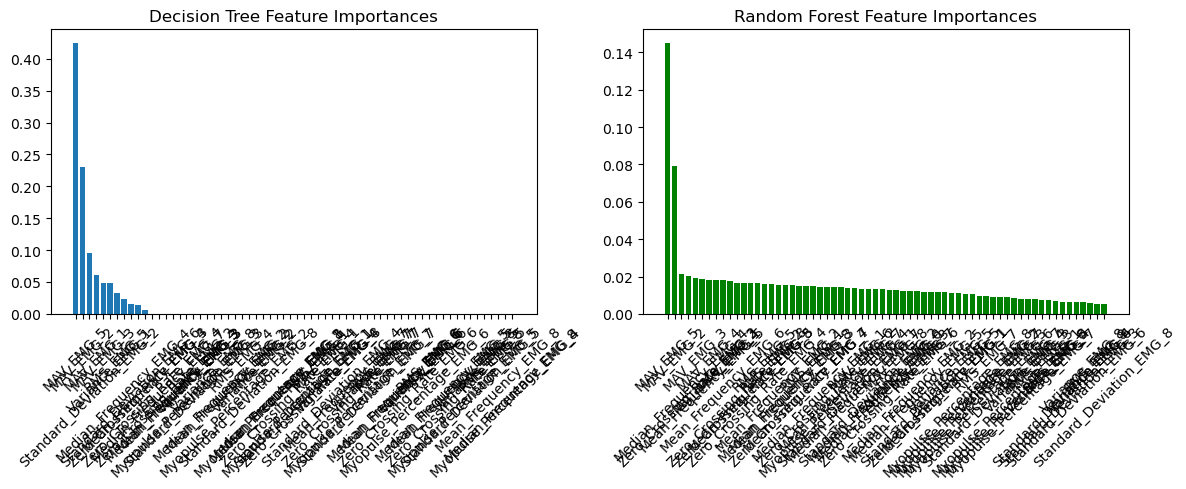

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# User-chosen parameters (edit based on the results of section 4.3)
max_depth = 4     # for the Decision Tree
n_estimators = 100 # for the Random Forest

# Instantiate and fit the best Decision Tree
best_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
best_tree.fit(X_train_final, y_train_final)

# Instantiate and fit the best Random Forest
best_forest = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
best_forest.fit(X_train_final, y_train_final)

feature_names = X_df.columns  # Using original column names

tree_importances = best_tree.feature_importances_
forest_importances = best_forest.feature_importances_

# Sort features by importance for each model
tree_sorted_idx = np.argsort(tree_importances)[::-1]
forest_sorted_idx = np.argsort(forest_importances)[::-1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Decision Tree Feature Importances")
plt.bar(range(len(tree_importances)), tree_importances[tree_sorted_idx], align='center')
plt.xticks(range(len(tree_importances)), feature_names[tree_sorted_idx], rotation=45)

plt.subplot(1, 2, 2)
plt.title("Random Forest Feature Importances")
plt.bar(range(len(forest_importances)), forest_importances[forest_sorted_idx], align='center', color='green')
plt.xticks(range(len(forest_importances)), feature_names[forest_sorted_idx], rotation=45)

plt.tight_layout()
plt.show()

In [53]:
for i in range (len(forest_importances)):
    print(f"Feature {i}: {forest_importances[forest_sorted_idx[i]]}")
    print(f"Feature {i}: {feature_names[forest_sorted_idx[i]]}")

Feature 0: 0.14509729540209096
Feature 0: MAV_EMG_5
Feature 1: 0.07934971168165321
Feature 1: MAV_EMG_2
Feature 2: 0.02131220080655665
Feature 2: Median_Frequency_EMG_4
Feature 3: 0.02049259836481327
Feature 3: Zero_Crossing_Rate_EMG_3
Feature 4: 0.01896651487339917
Feature 4: MAV_EMG_3
Feature 5: 0.018415450385998997
Feature 5: Mean_Frequency_EMG_5
Feature 6: 0.018382941910569432
Feature 6: MAV_EMG_4
Feature 7: 0.01822429994849485
Feature 7: Variance_EMG_2
Feature 8: 0.018036799350335923
Feature 8: Mean_Frequency_EMG_6
Feature 9: 0.01781469773443118
Feature 9: MAV_EMG_1
Feature 10: 0.01664514527642009
Feature 10: Zero_Crossing_Rate_EMG_8
Feature 11: 0.016536312921092734
Feature 11: Zero_Crossing_Rate_EMG_5
Feature 12: 0.016450813782828297
Feature 12: Mean_Frequency_EMG_8
Feature 13: 0.016275685206949424
Feature 13: Zero_Crossing_Rate_EMG_4
Feature 14: 0.016053226536262073
Feature 14: RMS_EMG_5
Feature 15: 0.01603930722058303
Feature 15: RMS_EMG_2
Feature 16: 0.015617701334905065
Featu

In [54]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=0)
CV_errors = []
print(X_train.shape)
print(y_train.shape)
for train_index, test_index in kf.split(X_train):
    X_train_f, X_test_f = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_train_f, Y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]


    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42).fit(X_train_f, Y_train_f)
    Y_hat = model.predict(X_test_f)

    CV_errors.append(nmse(Y_test_f, Y_hat))
print ("Cross-Validation NMSE:", np.mean(CV_errors))

(3446, 64)
(3446, 48)
Cross-Validation NMSE: 6730.909203230634


In [55]:
Y_df.describe()  # Display the first 10 rows of the DataFrame

,Position_1,Position_2,Position_3,Position_4,Position_5,Position_6,Position_7,Position_8,Position_9,Position_10,...,Position_39,Position_43,Position_44,Position_45,Position_46,Position_47,Position_48,Position_49,Position_50,Position_51
count,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,...,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000
mean,34.056098,-61.498245,-9.835739,30.854435,2.922714,-11.692690,-8.494104,7.876489,-16.412158,9.757605,...,-22.000154,10.024845,9.048219,-12.742775,-5.306220,5.526163,-28.427289,-0.535638,-5.412842,-15.074803
std,3.472835,1.427203,10.574451,0.476530,4.766314,2.448998,0.825032,0.357342,13.270371,1.770916,...,21.345268,0.957025,4.222721,26.375010,0.833793,1.217082,36.466896,0.739948,0.437315,19.414356
min,26.672331,-68.618897,-47.245063,28.608071,-11.653887,-18.978748,-10.024081,6.746179,-49.499482,5.495360,...,-77.465595,7.863220,-1.764066,-84.011450,-7.010780,4.873608,-106.711995,-2.378817,-5.636456,-69.965073
25%,32.017029,-61.045274,-9.124768,30.622460,0.074241,-13.167342,-9.001094,7.922975,-18.899826,10.032351,...,-44.680318,10.177767,6.957332,-6.682005,-5.242275,4.902549,-18.262505,-0.456348,-5.630406,-11.880811
50%,32.761662,-60.852066,-5.762407,30.939540,2.874452,-11.734089,-8.624310,8.020630,-13.907600,10.504829,...,-10.324730,10.428215,10.419859,-1.361179,-4.932495,4.922804,-11.148066,-0.203203,-5.620625,-6.275799
75%,33.986009,-60.779932,-3.744259,31.202689,5.777066,-10.235839,-8.296223,8.095454,-8.298116,10.791919,...,-8.955389,10.553413,11.710761,1.538570,-4.816231,5.004415,-8.525209,-0.094067,-5.580274,-3.881858
max,44.928242,-60.723897,10.241771,31.603551,20.304752,-2.644538,-6.579150,8.137032,6.714728,11.182037,...,-5.699604,11.608331,20.814592,24.681866,-4.372977,8.208076,1.332681,0.120605,-3.913330,0.811386


In [56]:
def nmse(y, y_hat):
    return np.mean((y - y_hat)**2) / np.std(y)**2

def calculate_nmse_per_column(df_true, df_predicted):
    """Calcule le NMSE pour chaque colonne de deux DataFrames."""
    nmse_values = {}
    if df_true.shape != df_predicted.shape:
        raise ValueError("Les deux DataFrames doivent avoir la même taille.")
    if not all(df_true.columns == df_predicted.columns):
        print("Attention : Les noms de colonnes ne correspondent pas nécessairement.")

    for col in df_true.columns:
        y_true = df_true[col].values
        y_predicted = df_predicted[col].values
        nmse_values[col] = nmse(y_true, y_predicted)
    return pd.Series(nmse_values)

In [57]:
correlations = np.abs(X_train.corrwith(y_train))
print(correlations)
raise ValueError("Stop here to check the correlations")
ranking_corr_idx = correlations.sort_values(ascending=False).index
print(ranking_corr_idx)
# Ensure that ranking_corr_idx only contains valid feature names from X_train
ranking_corr_idx = [col for col in ranking_corr_idx if col in X_train.columns]

CV_err = np.zeros((n,48))

fold_id = 0
for train_index, test_index in kf.split(X_train):
    X_tr, X_ts = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_tr, Y_ts = y_train.iloc[train_index], y_train.iloc[test_index]
    
    for nb_features in range(1, n+1):
        selected_features = ranking_corr_idx[:nb_features]
        model = LinearRegression()
        model.fit(X_tr[selected_features], Y_tr)
        Y_hat_ts = model.predict(X_ts[selected_features])
        CV_err[nb_features-1, fold_id] = nmse(Y_ts.values, Y_hat_ts)
    fold_id += 1

for i in range(n):
    print("#Features:", i+1, "; CV error=", round(np.mean(CV_err[i,:]),4),
          "; std dev=", round(np.std(CV_err[i,:]),4))

print("Correlation ranking:")
print(ranking_corr_idx)

MAV_EMG_1                  NaN
MAV_EMG_2                  NaN
MAV_EMG_3                  NaN
MAV_EMG_4                  NaN
MAV_EMG_5                  NaN
                            ..
Zero_Crossing_Rate_EMG_4   NaN
Zero_Crossing_Rate_EMG_5   NaN
Zero_Crossing_Rate_EMG_6   NaN
Zero_Crossing_Rate_EMG_7   NaN
Zero_Crossing_Rate_EMG_8   NaN
Length: 112, dtype: float64


ValueError: Stop here to check the correlations

In [ ]:
print(y_train)


                              Position_1  Position_2  Position_3  Position_4  \
Feature_Vector_789_session_4   32.035566  -60.779959   -3.802412   30.995411   
Feature_Vector_489_session_1   32.844268  -60.861772   -5.986836   30.983233   
Feature_Vector_426_session_3   38.343688  -62.543901  -21.966334   29.584773   
Feature_Vector_612_session_4   31.087820  -60.730607   -1.274401   31.276667   
Feature_Vector_287_session_3   40.636633  -63.979405  -29.599677   30.073296   
...                                  ...         ...         ...         ...   
Feature_Vector_751_session_4   31.707744  -60.757090   -2.924107   31.252512   
Feature_Vector_467_session_0   40.633682  -63.977380  -29.589542   30.100957   
Feature_Vector_336_session_3   41.617922  -64.773883  -33.153760   29.953128   
Feature_Vector_97_session_4    31.598321  -60.750871   -2.631986   31.198128   
Feature_Vector_861_session_0   33.147088  -60.902311   -6.812572   31.189452   

                              Position_

In [ ]:
print(y_train.iloc[0:3])

                              Position_1  Position_2  Position_3  Position_4  \
Feature_Vector_789_session_4   32.035566  -60.779959   -3.802412   30.995411   
Feature_Vector_489_session_1   32.844268  -60.861772   -5.986836   30.983233   
Feature_Vector_426_session_3   38.343688  -62.543901  -21.966334   29.584773   

                              Position_5  Position_6  Position_7  Position_8  \
Feature_Vector_789_session_4    3.433715  -11.446307   -8.504572    7.988596   
Feature_Vector_489_session_1    3.309906  -11.510036   -8.075896    7.839203   
Feature_Vector_426_session_3   -6.762592  -16.599633   -6.790008    6.975833   

                              Position_9  Position_10  ...  Position_39  \
Feature_Vector_789_session_4  -15.715973    10.665158  ...    -7.269010   
Feature_Vector_489_session_1  -22.334364    10.146963  ...   -10.787563   
Feature_Vector_426_session_3  -44.979865     5.598147  ...   -60.262542   

                              Position_43  Position_44  P